# Score Accuracy on test set

Input:
- DLCC dataset 
- Result of DL-Learner

Output:

- Accuracy heatmap for the first 10 symbolic models per DLCC test case


Restriction: only works for standard refinement operator, adapted rho refinement operator produces concepts that the owlapy library cannot transform into a SPARQL Query

How to use: Input the paths and run all

In [1]:
# standard imports
import numpy as np
import pandas as pd

C:\Users\raine\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\raine\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# OwlParser and SPARQL Converter
from owlapy.parser import DLSyntaxParser
from owlapy.parser import ManchesterOWLSyntaxParser
from owlapy.parser import MANCHESTER_GRAMMAR as g
from owlapy.owl2sparql.converter import Owl2SparqlConverter

# rdflib + dependencies
import logging
import sys
from pathlib import Path

import rdflib

# reasoning
from pyfactxx import coras
from pyfactxx.coras.cli import load_and_parse

# accuracy metrics
import seaborn as sns
from sklearn.metrics import accuracy_score

#tqdm
from tqdm import tqdm

# time
import time

In [4]:
# SET ALL PATHS
# Test set Directory
test_set_directory = '../data/Generated Datasets/synthetic_ontology20/'
patterns = ['tc01','tc02','tc03','tc04','tc05','tc06','tc07','tc08','tc09','tc10','tc11','tc12']
intermediate = '/synthetic_ontology/'
# change amount here
path_to_split = intermediate + '20/train_test/'

# results of DLCC Generator are misnamed; train and test are switched
# Train test not switched for 1000 instances 
test_file='train.txt'
namespace='http://example.org/'
graph_suffix ='_full.nt'
dlcc_config = 'configuration.txt'

# result directory
result_dir = '../data/DL-Learner_outputs/Celoe_initial/res20-20.03/'
res_file_suffix = 'Res.txt'

# PATH TO RESULT to save heatmap later
result_fig = result_dir 


In [4]:
def retrieve_model_if_present(result_path:str, model_nr:int):
    with open(result_path) as f:
        datafile = f.readlines()
    found = False
    model = False
    search_str = str(model_nr)+': '
    for line in datafile:
        if found:
            # find specific model
            if search_str in line:
                model = True
                model_str = line
                # only loop until required line
                break;
        # Solutions string only present if a symbolic model has been created by DL-Learner
        if 'solutions:' in line:
            found = True
    # required line has been found
    if found & model:
        strip = model_str.removeprefix(search_str).removesuffix('\n')
        sep = '(pred. acc.:'
        # strip predicted model accuracy, leaves symbolic model als owl triple string
        stripped = strip.split(sep, 1)[0]
        return stripped
    # impicit else: 
    # only happens if no models have been generated (example -> DL-Learner finished on an exception)
    return 'noModel'

In [5]:
def convert_model_string_to_sparql(model_string):
    # initialize parser
    p = ManchesterOWLSyntaxParser(namespace=namespace)
    # parse to owl class expression
    ce = p.parse_expression(expression_str = model_string)
    # convert to sparql
    conv = Owl2SparqlConverter()
    query = conv.as_query(root_variable='?x', ce=ce)
    #print(query)
    return query

In [6]:
def build_queries_for_pattern(result_path:str):
    # Query Arraylist -> Quarray
    quarray = []
    # this is inefficient, code has grown historically
    for i in range(10):
        # range starts counting at 0; DL-Learner solutions start counting at 1
        i =i+1
        model_str = retrieve_model_if_present(result_path, i)
        if 'noModel' in model_str:
            print(f"Warning: No Model could be retrieved from {result_path}.")
            print(f"Debug: 'noModel' at index {i}")
            # append empty string for error handling -> done in a later method
            quarray.append('noModel')
            continue
        else:
            query = convert_model_string_to_sparql(model_str)
            quarray.append(query)
    return quarray

In [7]:
def build_query_df():
    df = pd.DataFrame(columns=patterns)
    for p in tqdm(patterns, desc = "Building queries from symbolic models"):
        # retrieve result file txt
        result_path = result_dir + p + res_file_suffix
        querylist = build_queries_for_pattern(result_path)
        df[p] = querylist
    return df

In [8]:
def generate_pred(x_test, result_set):
    # is test data found in result set? -> positive class
    if x_test in result_set:
        return 1
    else: # -> negative class
        return 0

In [9]:
def get_kb(path:str, doReason:bool):
    if doReason:
        start = time.time() 
        crs = coras.Coras()
        # this lib does not read .nt files 
        # .nt is a subset of n3 
        # // src= https://etutorials.org/Misc/Practical+resource+description+framework+rdf/Chapter+2.+RDF+Heart+and+Soul/2.5+RDF+Serialization+N3+and+N-Triples/
        crs.load(path, format='n3')
        crs.parse()
        # reasoning: Do once per pattern! It takes some time
        crs.realise()
        end = time.time()
        print(f"Total runtime of the ontology materialization is {end - start}")
    else:
        # more efficient for large ontologies than the lib above
        crs = rdflib.Graph()
        # this library can read nt files -> prefer
        crs.parse(path, format="nt")
    return crs

In [10]:
def for_pattern(p:str, doReason:bool, queries):
    ontology_path =  test_set_directory + p + intermediate + p + graph_suffix
    # get KB from ontology file
    crs = get_kb(ontology_path, doReason)
    # list to collect accuracies
    mdl_accuracies = []
    # obtain test data
    test_path= test_set_directory + p + path_to_split + test_file
    test_data = pd.read_csv(filepath_or_buffer=test_path, header= None, sep='\t')
    # fix format
    test_data[0] = test_data[0].map(lambda x: x.removeprefix('<').removesuffix('>'))
    y_test = test_data[:][1]
    X_test = test_data[:][0]
    for query in tqdm(queries):
        # query the knowledge base
        result_set = crs.query(query)
        # get query result set
        returnlist = []
        for row in result_set:
            # this takes a lot of time but is necessary (?)
            assert isinstance(row, rdflib.query.ResultRow)
            # formatting the returned results to match test data
            returnlist.append(str(row.x).removeprefix(namespace))
        # check if X_test is in result set
        y_pred = X_test.apply(lambda x: generate_pred(x, set(returnlist)))
        # score
        acc = accuracy_score(y_test, y_pred)
        # append score to list
        mdl_accuracies.append(acc)
    # return list of 10 accuracies; one per query 
    return(mdl_accuracies)

In [11]:
def generate_figure(df, saveFigPath):
    %matplotlib inline
    plot = sns.heatmap(df,vmin = 0.3, vmax = 1, annot=True)
    plot.set_yticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10 '])
    plot.tick_params(axis='x', labelrotation=45)
    plot.set_ylabel("Symbolic Models")
    plot.tick_params(axis='y', labelrotation=0)
    fig = plot.get_figure()
    #fig.savefig(saveFigPath)

In [12]:
def run(doReason:bool, savePath:str):
    heatmap = pd.DataFrame(columns=patterns)
    all_queries = build_query_df()
    loop = tqdm(patterns)
    for p in loop:
        loop.set_description(f"Processing {p}")
        pattern_queries = all_queries[p]
        if 'noModel' in list(pattern_queries):
            # -1 as return if DL-Learner has noModel
            heatmap[p] = np.full((10), -1)
            # skip to next pattern
            continue
        pattern_accuracies = for_pattern(p,doReason,pattern_queries)
        heatmap[p] = pattern_accuracies
    generate_figure(heatmap, savePath)

Processing tc01:   0%|                                                                          | 0/12 [00:00<?, ?it/s]

Total runtime of the ontology realization is 0.4131495952606201



Processing tc02:   8%|█████▌                                                            | 1/12 [00:09<01:40,  9.17s/it]

Total runtime of the ontology realization is 0.4245128631591797



Processing tc03:  17%|███████████                                                       | 2/12 [00:09<00:41,  4.14s/it]

Total runtime of the ontology realization is 0.3343827724456787



Processing tc04:  25%|████████████████▌                                                 | 3/12 [00:19<01:01,  6.83s/it]

Total runtime of the ontology realization is 0.48105382919311523



Processing tc05:  33%|██████████████████████                                            | 4/12 [01:32<04:23, 32.88s/it]

Total runtime of the ontology realization is 0.430706262588501



Processing tc06:  42%|███████████████████████████▌                                      | 5/12 [01:42<02:52, 24.68s/it]

Total runtime of the ontology realization is 0.42416858673095703



Processing tc07:  50%|█████████████████████████████████                                 | 6/12 [01:52<01:56, 19.45s/it]

Total runtime of the ontology realization is 0.4058363437652588



Processing tc08:  58%|██████████████████████████████████████▌                           | 7/12 [02:01<01:20, 16.06s/it]

Total runtime of the ontology realization is 0.32535409927368164



Processing tc09:  67%|████████████████████████████████████████████                      | 8/12 [02:11<00:56, 14.15s/it]

Total runtime of the ontology realization is 0.4439845085144043



Processing tc10:  75%|█████████████████████████████████████████████████▌                | 9/12 [02:24<00:41, 13.79s/it]

Total runtime of the ontology realization is 0.672105073928833



Processing tc11:  83%|██████████████████████████████████████████████████████▏          | 10/12 [02:50<00:35, 17.77s/it]

Total runtime of the ontology realization is 0.4127659797668457



Processing tc12:  92%|███████████████████████████████████████████████████████████▌     | 11/12 [03:04<00:16, 16.37s/it]

Total runtime of the ontology realization is 0.38105344772338867



Processing tc12: 100%|█████████████████████████████████████████████████████████████████| 12/12 [03:15<00:00, 16.27s/it]


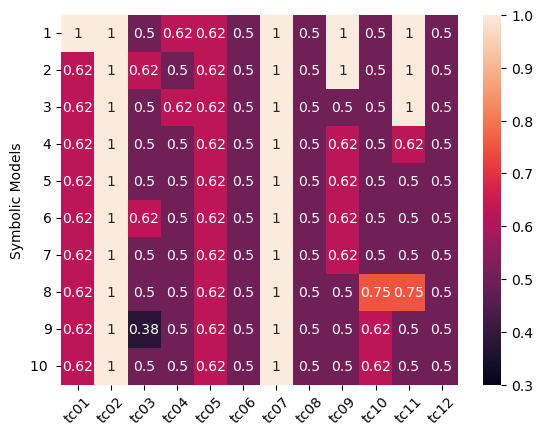

In [13]:
run(True, result_dir + 'with_Reasoning.png')

Processing tc12: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:55<00:00,  4.59s/it]


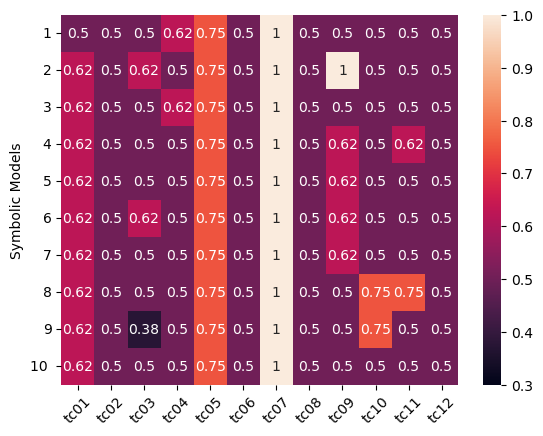

In [14]:
run(False, result_dir + 'no_Reasoning.png')

In [15]:
print("Finish :)")

Finish :)
